In [1]:
import xarray as xr
import numpy  as np
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import proplot as plot

从mask后的数据计算每月的情况，将13年的4-8月绘制热图比较<br>

此处简单地做了个减法

remains:绘制更多统计量的

为了方便不更换变量名，用计算后的变量rmsd复制到此前的vr_mean上<br>
对于RMSD的计算还存疑，是先进行了直接做差之后的平方，之后在平均之后开根，类似于每个空间pattern做了一个RMSD，在每个时间维度上，这里需不需要提前对空间pattern做月平均？

0328
    
    修改为先进行月平均图的计算之后再进行空间pattern的RMSD的计算

In [2]:
# 确定绘制的种类

partial_list = ["NE", "NC", "YZ", "SW"]
seasons_list = ['am', 'jja']
bias_dict = {}
rmsd_dict = {}
corr_dict = {}

for season in seasons_list:
    
    bias_region_dict = {}
    rmsd_region_dict = {}
    corr_region_dict = {}
    
    for region in partial_list:

        # 读取数据
        main_path = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/partial_pre/"+region+"/mask_res_interannual/"

        dir_vr = main_path + season +"_mask_vr_pre_98-17.nc"
        ds_vr = xr.open_dataset(dir_vr)
        # ds_vr

        # dir_rcm = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/pre/" + "daily_pre_03-15.nc"
        dir_rcm = main_path + season + "_mask_rcm_pre_98-17.nc"
        ds_rcm = xr.open_dataset(dir_rcm)
        # ds_rcm

        obs_cn051 = main_path + season + "_mask_sel_CN05.1_Pre_1961_2018_daily_025x025.nc"
        ds_cn051 = xr.open_dataset(obs_cn051)

        # 整理数据

        obs_years  = ds_cn051['pre']
        vr_years   = ds_vr['precip_MPAS']
        rcm_years  = ds_rcm['precip_MPAS']

        # rename coordinate name,和模式中的latitude longitude一样的经纬度坐标名
        rename_coords = dict(zip(obs_years.dims, vr_years.dims))
        obs_years     = obs_years.rename(rename_coords)

        # 计算RMSD，先取平方再开根
        vr_rmsd_temp  = (vr_years.values - obs_years.values)**2
        rcm_rmsd_temp = (rcm_years.values - obs_years.values)**2

        vr_rmsd_xr  = xr.DataArray(vr_rmsd_temp, coords = vr_years.coords)
        rcm_rmsd_xr = xr.DataArray(rcm_rmsd_temp, coords = rcm_years.coords)

        vr_rmsd  = np.sqrt(vr_rmsd_xr.mean(dim=["longitude","latitude"]))
        rcm_rmsd = np.sqrt(rcm_rmsd_xr.mean(dim=["longitude","latitude"]))

        # 计算BIAS
        vr_bias  =  vr_years.mean(dim=["longitude","latitude"]) - obs_years.mean(dim=["longitude","latitude"])
        rcm_bias = rcm_years.mean(dim=["longitude","latitude"]) - obs_years.mean(dim=["longitude","latitude"])

        # 计算空间pattern的corr
        vr_corr  = xr.corr(obs_years,  vr_years, dim=['latitude','longitude']).dropna(dim='Time')
        rcm_corr = xr.corr(obs_years, rcm_years, dim=['latitude','longitude']).dropna(dim='Time')

        # 合并到dict
        bias_region_dict[region] = {"vr":vr_bias, "rcm":rcm_bias} 
        rmsd_region_dict[region] = {"vr":vr_rmsd, "rcm":rcm_rmsd} 
        corr_region_dict[region] = {"vr":vr_corr, "rcm":rcm_corr}
    
    # 合并到季节的dict
    bias_dict[season] = bias_region_dict
    rmsd_dict[season] = rmsd_region_dict
    corr_dict[season] = corr_region_dict

In [3]:
# 数据测试
rmsd_dict['jja']['YZ']['vr']

<xarray.DataArray (Time: 20)>
array([4.59355442, 4.00892665, 3.69391348, 2.41811714, 2.84381702,
       2.69322626, 2.00656686, 2.99963727, 3.18584827, 2.24095668,
       3.74100623, 1.92623523, 3.54360319, 3.73333282, 2.14600417,
       2.55870151, 2.92150552, 3.67060018, 3.84064338, 3.29325737])
Coordinates:
  * Time     (Time) datetime64[ns] 1998-07-16T12:00:00 ... 2017-07-16T12:00:00

绘制分区的结果

BIAS

进行折线图的尝试，但是不方便在一个年份上比较大小，所以考虑后面的柱状图

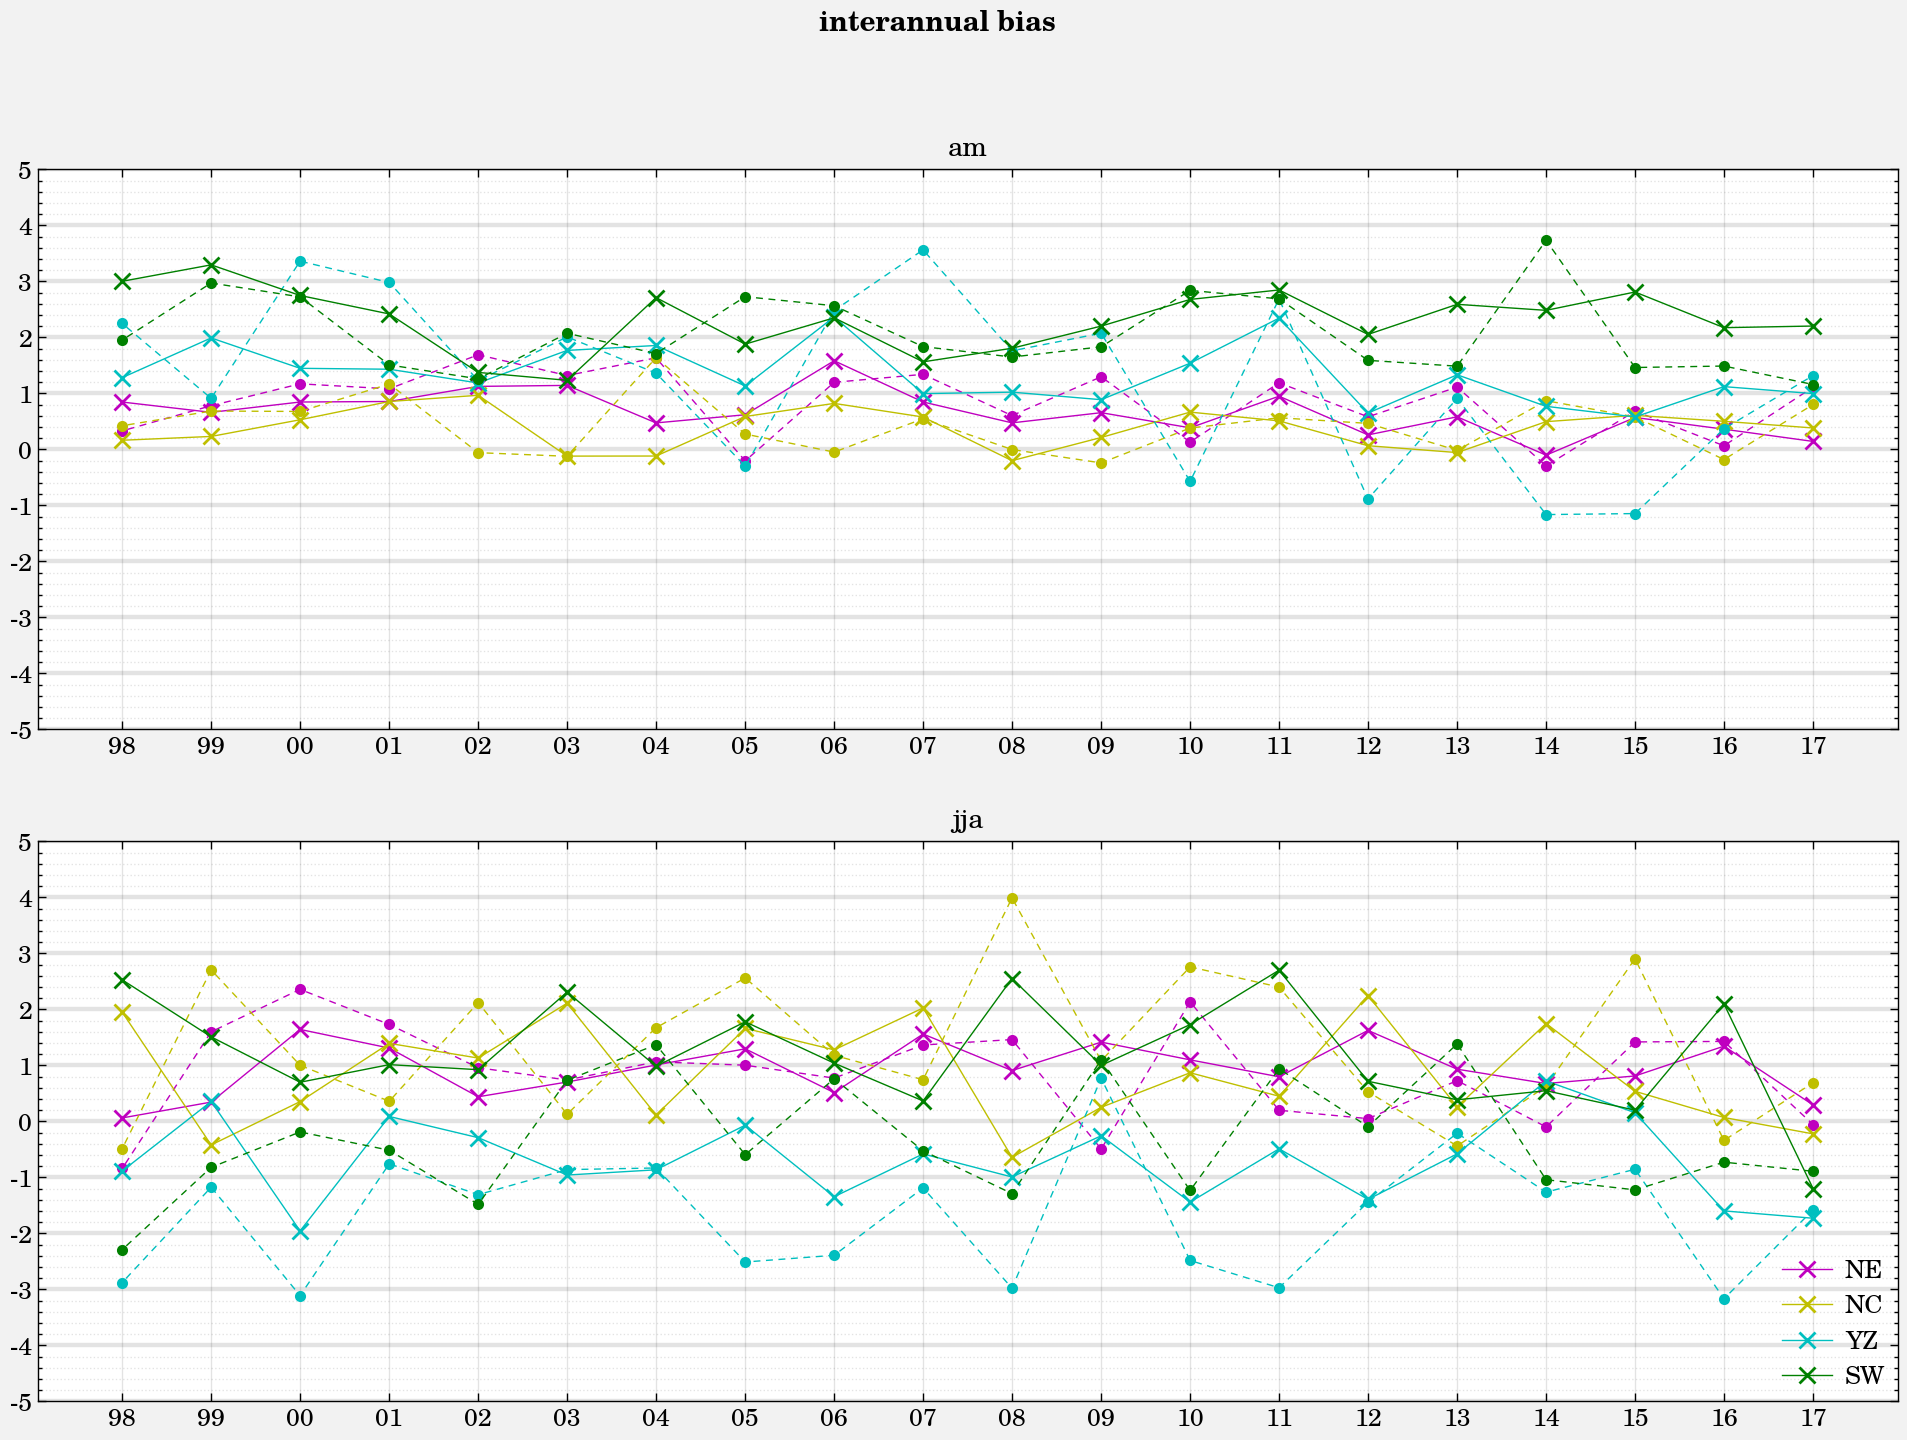

In [40]:
import matplotlib.dates as dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# import matplotlib.pyplot as plt
# plt.style.use(['science', 'no-latex', 'cjk-tc-font'])
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展
fig,ax = plt.subplots(2,1,figsize=(12,8))
# loop region and seasons
partial_list = ["NE", "NC", "YZ", "SW"] # loop region
seasons_list = ['am', 'jja']            # loop season
color_plot = ["m","y","c","g"]          # loop color
time_idx = pd.date_range(start = "1998-01-01", end = "2017-01-01",freq='AS') # add time coords


for iseason, season in enumerate(seasons_list):
    for iregion, region in enumerate(partial_list):

        plot_xr = bias_dict[season][region]['vr']
        ax[iseason].plot(time_idx, plot_xr, linestyle = (5, (5, 4)) , color =color_plot[iregion], marker = '.'\
            , linewidth = .5)
        plot_xr = bias_dict[season][region]['rcm']
        ax[iseason].plot(time_idx, plot_xr, linestyle = '-', color =color_plot[iregion], marker = 'x', label = region, linewidth = .5)
        # corr
        # ymin = -1.
        # ymax = 1.
        # rmsd
        ymin = -3.2
        ymax = 4
        ax[iseason].set_ylim([ymin,ymax])

        # ax[iseason].set_xlim([xmin,xmax])
        # ax[iseason].xaxis.grid(True, which="minor", linestyle = ":")
        ax[iseason].xaxis.grid(True, which="major", linestyle = "-")
        ax[iseason].yaxis.grid(True, which="minor", linestyle = ":")
        ax[iseason].yaxis.grid(True, which="major", linestyle = "-", linewidth = 1.6)

        ax[iseason].yaxis.set_major_locator(MultipleLocator(1.))
        ax[iseason].yaxis.set_minor_locator(MultipleLocator(.2))
        ax[iseason].yaxis.set_major_formatter(FormatStrFormatter('%1.f'))

        # ax[iseason].set_ylabel()
        # ax[iseason].get_legend().remove()
        ax[iseason].xaxis.set_minor_locator(dates.YearLocator())
        ax[iseason].xaxis.set_minor_formatter(dates.DateFormatter('%y'))
        ax[iseason].xaxis.set_major_locator(dates.YearLocator())
        ax[iseason].xaxis.set_major_formatter(dates.DateFormatter('%y'))
        
        ax[iseason].set_title(season)
    
ax[iseason].legend(loc = 'lower right')
plt.suptitle("interannual bias")
plt.savefig("./output_pic/bias_interannual.png", dpi = 300, facecolor = "white")

# 用proplot修改绘图风格，绘制bar plot
# ----- 施工中 -----

In [ ]:
corr_dict['jja']['YZ']

In [35]:
from matplotlib.dates import date2num
# date2num(time_idx)
delta_time = date2num(time_idx)[1] - date2num(time_idx)[0]
delta_time
delta = 0.2 * delta_time
delta

73.0

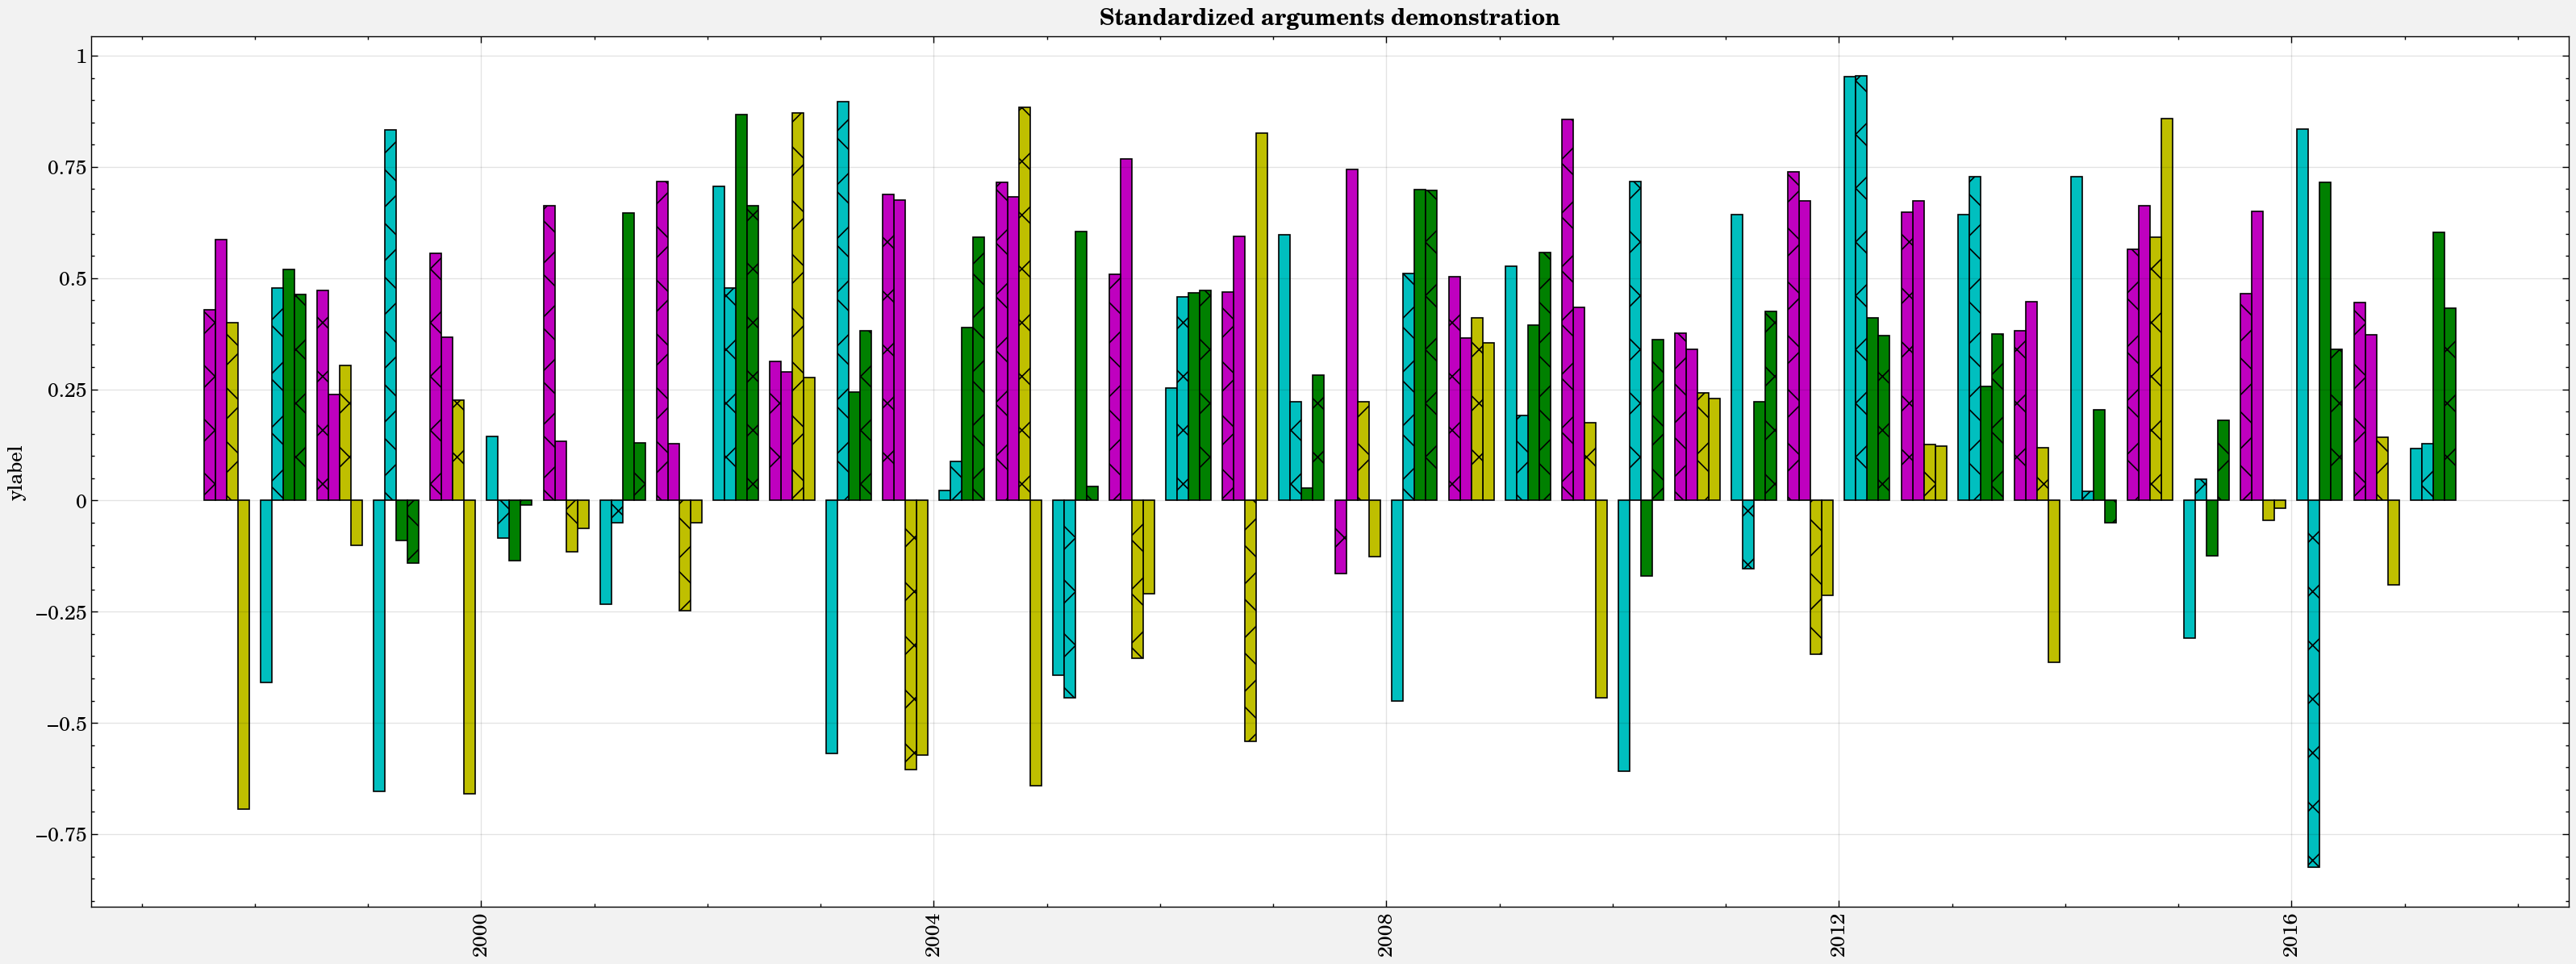

In [36]:
import matplotlib.dates as dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# import matplotlib.pyplot as plt
# plt.style.use(['science', 'no-latex', 'cjk-tc-font'])

# loop region and seasons
partial_list = ["NE", "NC", "YZ", "SW"] # loop region
seasons_list = ['am', 'jja']            # loop season
color_plot = ["m","y","c","g"]          # loop color
time_idx = pd.date_range(start = "1998-01-01", end = "2017-01-01",freq='AS') # add time coords
# time_idx = np.arange(1998,2018,1)

fig, axs = plot.subplots(ncols=1, nrows = 1, figsize=(16,6))
axs.format(xlabel='xlabel', ylabel='ylabel')
axs.format(suptitle='Standardized arguments demonstration')
axs_ind = axs[0]
axs_ind.bar(date2num(time_idx)-delta*3/2, corr_dict['jja']['NE']['vr'], width=0.1, label='am yz vr',color='m')
axs_ind.bar(date2num(time_idx)-delta/2, corr_dict['jja']['NC']['vr'], width=0.1, label='am yz vr',color='y')
axs_ind.bar(date2num(time_idx)+delta/2, corr_dict['jja']['YZ']['vr'], width=0.1, label='am yz vr',color='c')
axs_ind.bar(date2num(time_idx)+delta*3/2, corr_dict['jja']['SW']['vr'], width=0.1, label='am yz vr',color='g')

axs_ind.bar(date2num(time_idx)-delta*4/2, corr_dict['jja']['NE']['rcm'], width=0.1, label='am yz rcm',color='m',hatch="x")
axs_ind.bar(date2num(time_idx)-delta*2/2, corr_dict['jja']['NC']['rcm'], width=0.1, label='am yz rcm',color='y',hatch="x")
axs_ind.bar(date2num(time_idx)+delta*2/2, corr_dict['jja']['YZ']['rcm'], width=0.1, label='am yz rcm',color='c',hatch="x")
axs_ind.bar(date2num(time_idx)+delta*4/2, corr_dict['jja']['SW']['rcm'], width=0.1, label='am yz rcm',color='g',hatch="x")
# axs_ind.bar(date2num(time_idx)+delta/2, corr_dict['am']['SW']['vr'], width=0.2, label='am sw vr')
# p1 = axs_ind.bar(date2num(time_idx)+delta/2, corr_dict['am']['SW']['rcm'], width=0.2, label='am sw rcm')
# axs.bar_label(p1, label_type='center')
axs_ind.xaxis_date()

